In [1]:
#import dependencies
import pandas as pd
import numpy as np
import random as rn
from datetime import datetime
import gym
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization
import tensorflow as tf
from tensorflow.losses import huber_loss
import os
from keras.utils import plot_model
from IPython.display import Image
from matplotlib import pyplot as plt
import seaborn as sns


# Add graphviz to PATH environmental variable (for NN model architecture visualizations)
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Set randomization defaults for solution reproducability
np.random.seed(21)
rn.seed(21)
tf.set_random_seed(21)

# Set conditions for keras result reproducability
session_conf = tf.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
sess = tf.Session(graph = tf.get_default_graph(), config = session_conf)
K.set_session(sess)

# Set visualization defaults
sns.set_context('notebook')


%matplotlib inline 

Using TensorFlow backend.


In [2]:
env = gym.make('SpaceInvaders-v0')

obs = env.reset()

print(obs.shape)
print(env.action_space)

(210, 160, 3)
Discrete(6)


In [3]:
def process_image(obs):
    img = obs[8:195:2, ::2]
    img = (img.mean(axis = 2) - 128) # convert to greyscale, center to [-128, 128]
    img = img.astype(np.uint8)  # cast as integers
    img = img.reshape((1,) + img.shape + (1,)) # reshape to 1 x H x L x 1 for Keras compatibility
    return img # return 3D numpy array

Processed Image Dimension: 1 x 94 x 80 x 1


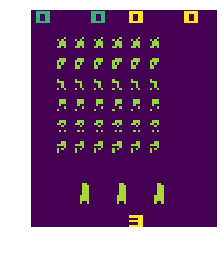

In [4]:
img = process_image(obs)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.axis("off")
plt.imshow(img.reshape(img.shape[1], img.shape[2]))

img_shape = img.shape

print('Processed Image Dimension: {:} x {:} x {:} x {:}'.format(img_shape[0], img_shape[1], img_shape[2], img_shape[3]))

In [5]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = int(maxlen)
        self.buf = np.empty(shape = self.maxlen, dtype = np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement = True):
        if with_replacement:
            indices = np.random.randint(self.length, size = batch_size)
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [6]:
def sample_memories(memory_store, batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in memory_store.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

class DDQNAgent:
    def __init__(self, image_shape, action_space, learning_rate, rho, optimizer_epsilon, replay_memory, gamma, epsilon_max, epsilon_min, epsilon_steps):
        self.image_shape = image_shape
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.rho = rho
        self.optimizer_epsilon = optimizer_epsilon
        self.memory = replay_memory
        self.gamma = gamma
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = (epsilon_max - epsilon_min)/epsilon_steps
        self.epsilon = epsilon_max
        self.model = self._build_model() # instantiate core model
        self.target_model = self._build_model() # instantiate target model
        self._update_target_model() # set model weights equal for core and target models
    
    def _build_model(self):
        # neural net to approximate Q-value function:
        model = Sequential()
        
        model.add(Conv2D(32, 8, strides = 4, padding = "valid", activation = "relu", input_shape = self.image_shape, 
                 data_format = "channels_last"))
        model.add(Conv2D(64, 4, strides = 2, padding = "valid", activation = "relu"))
        model.add(Conv2D(64, 3, strides = 1, padding = "valid", activation = "relu"))
        model.add(Flatten())
        model.add(Dense(512, activation = "relu"))
        model.add(Dense(action_space))
        
        model.compile(loss = huber_loss, optimizer = RMSprop(lr = self.learning_rate, rho = self.rho, epsilon = self.optimizer_epsilon))
        return model
    
    def _update_target_model(self):
        model_weights = self.model.get_weights()
        self.target_model.set_weights(model_weights)

    def act(self, state):
        state_proc = process_image(state)
        state_scaled = state_proc/128 # convert to [-1,1]
        epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.rand() < epsilon: # if acting randomly, take random action
            return rn.randrange(self.action_space)
        Q_values = self.model.predict(state_scaled)[0] # if not acting randomly, predict Q-values for current state
        return np.argmax(Q_values) # pick the action that will give the highest reward
         
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # list of previous experiences, enabling re-training later
       
    def train(self, batch_size): # method that trains NN with experiences sampled from memory
        state, action, reward, next_state, done = sample_memories(self.memory, batch_size)
        for state, action, reward, next_state, done in zip(state, action, reward, next_state, done): # extract data for each minibatch sample
            target = reward # if done (boolean whether game ended or not, i.e., whether final state or not), then target = reward
            state_scaled = state/128 # convert to [-1,1]
            next_state_scaled = next_state /128 # convert to [-1,1]
            if not done: # if not done, then predict future discounted reward
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state_scaled)[0])
            target_f = self.model.predict(state_scaled) # approximately map current state to future discounted reward
            target_f[0][action] = target
            history = self.model.fit(state_scaled, target_f, epochs = 1, verbose = 0) # single epoch of training with x=state, y=target_f; fit decreases loss btwn target_f and y_hat
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        return history
            
    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

In [7]:
# Set DQN Agent parameters

## Set RL environment parameters
input_shape = img.shape[1:]
action_space = env.action_space.n


# Set Adam optimizer learning parameters
lr = 0.00025
rho = 0.95
rmsprop_epsilon = 0.01

## Set Q-learning γ discount parameter
gamma = 0.99

## Set ε-greedy learning parameters for actor-agent
epsilon_max = 1
epsilon_min = 0.1
decay_steps = 10**4

## Set Rreplay memory parameters
replay_memory_size = 3.5 * 10**4
replay_memory = ReplayMemory(replay_memory_size)

## Set output directory for model storage
output_dir = 'DDQN_model_output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Instantiate Deep-Q Learning Agent
agent = DDQNAgent(input_shape, action_space, lr, rho, rmsprop_epsilon, replay_memory, gamma, epsilon_max, epsilon_min, decay_steps)

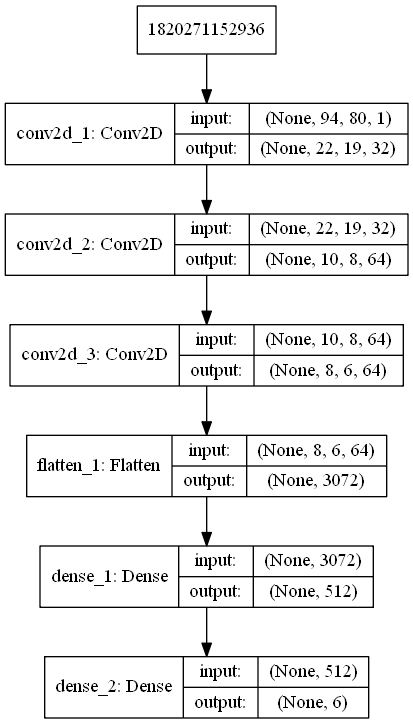

In [8]:
# Plot wide model archictecture
plot_model(agent.model, to_file = output_dir + 'ANN_architecture.png', show_shapes = True)
Image(retina = True, filename =  output_dir + 'ANN_architecture.png')

In [9]:
# Set training defaults
total_frames = 10**5

training_start = 5 * 10**3
training_frequency = 3
batch_size = 64

copy_steps = 10**3
save_steps = 10**3

run_dict = {    
    'game':     [],
    'score':       [],
    'epsilon':     [],
    'game length': []
}

loss_history = []

frames = 0
game = 0

start_time = datetime.now()

while total_frames > frames:

    done = False   
    state = env.reset()
    loss = np.nan
    
    score = 0
    game_length = 0
    
    while not done:
        
        env.render()

        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        
        score += reward
        frames += 1
        game_length += 1
        
        agent.remember(process_image(state), action, reward, process_image(next_state), done)
        
        state = next_state
        
        if frames >= training_start:
            if frames % training_frequency == 0:
                model_hist = agent.train(batch_size) 
                loss_history.append(model_hist.history['loss'][0])
        
            if frames % copy_steps == 0:
                agent._update_target_model()
            
            if frames % save_steps == 0:
                agent.save(output_dir + "weights_{:03d}K_frames.hdf5".format(int(frames/save_steps)))
                pd.Series(loss_history).to_csv(output_dir + 'training_loss.csv', index = False, header = False)
                pd.DataFrame.from_dict(run_dict).to_csv(output_dir + 'training_history.csv', index = False)
    
    run_dict['game'].append(game)
    run_dict['score'].append(score)
    run_dict['epsilon'].append(agent.epsilon)
    run_dict['game length'].append(game_length)
       
    game += 1
    
    print("Game: {:,d} ({:,d} Total Frames): Score: {:.0f} Points, Final Epsilon: {:.2f}, Game Length: {:,d} Moves".format(
        game, frames, score, agent.epsilon, game_length))   

end_time = datetime.now()

print('')
print("Training Time: {:}".format(end_time - start_time))

Game: 1 (397 Total Frames): Score: 80 Points, Final Epsilon: 1.00, Game Length: 397 Moves
Game: 2 (864 Total Frames): Score: 80 Points, Final Epsilon: 1.00, Game Length: 467 Moves
Game: 3 (1,701 Total Frames): Score: 155 Points, Final Epsilon: 1.00, Game Length: 837 Moves
Game: 4 (2,153 Total Frames): Score: 50 Points, Final Epsilon: 1.00, Game Length: 452 Moves
Game: 5 (3,055 Total Frames): Score: 215 Points, Final Epsilon: 1.00, Game Length: 902 Moves
Game: 6 (3,718 Total Frames): Score: 150 Points, Final Epsilon: 1.00, Game Length: 663 Moves
Game: 7 (4,393 Total Frames): Score: 85 Points, Final Epsilon: 1.00, Game Length: 675 Moves
Game: 8 (4,908 Total Frames): Score: 125 Points, Final Epsilon: 1.00, Game Length: 515 Moves
Game: 9 (5,268 Total Frames): Score: 90 Points, Final Epsilon: 0.99, Game Length: 360 Moves
Game: 10 (6,630 Total Frames): Score: 410 Points, Final Epsilon: 0.95, Game Length: 1,362 Moves
Game: 11 (7,754 Total Frames): Score: 290 Points, Final Epsilon: 0.92, Game 

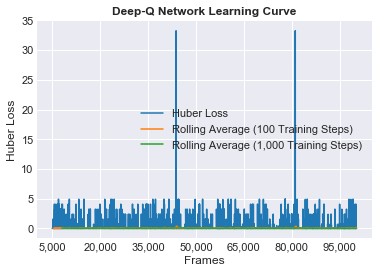

In [10]:
# Set visualization defaults
plt.style.use('seaborn-darkgrid')

loss = pd.Series(loss_history)

rolling_mean_loss_100 = loss.rolling(100).mean()
rolling_mean_loss_1K = loss.rolling(1000).mean()

# Plot Learning Curve
fig = plt.figure()

ax = fig.add_subplot(111)

plt.plot(loss, label = 'Huber Loss')
plt.plot(rolling_mean_loss_100, label = 'Rolling Average (100 Training Steps)')
plt.plot(rolling_mean_loss_1K, label = 'Rolling Average (1,000 Training Steps)')

plt.title('Deep-Q Network Learning Curve', fontweight = 'bold')


ax.set_xticklabels(['{:,.0f}'.format(training_start + x * training_frequency) for x in ax.get_xticks()])
plt.xlabel('Frames')
plt.ylabel('Huber Loss')

plt.legend()

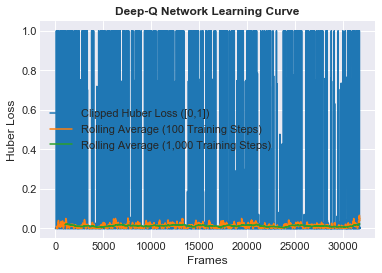

In [11]:
clipped_loss = pd.Series(np.minimum(np.array(loss), np.ones(len(loss))))

rolling_mean_clipped_loss_100 = clipped_loss.rolling(100).mean()
rolling_mean_clipped_loss_1K = clipped_loss.rolling(1000).mean()

plt.plot(clipped_loss, label = 'Clipped Huber Loss ([0,1])')
plt.plot(rolling_mean_clipped_loss_100, label = 'Rolling Average (100 Training Steps)')
plt.plot(rolling_mean_clipped_loss_1K, label = 'Rolling Average (1,000 Training Steps)')

plt.title('Deep-Q Network Learning Curve', fontweight = 'bold')


ax.set_xticklabels(['{:}'.format(training_start + x * training_frequency) for x in ax.get_xticks()])
plt.xlabel('Frames')
plt.ylabel('Huber Loss')

plt.legend()

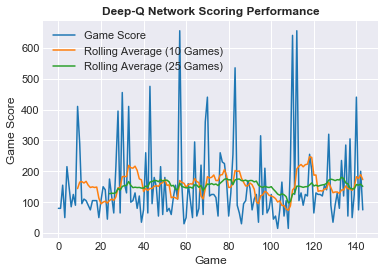

In [12]:
rolling_mean_score_10 = pd.Series(run_dict['score']).rolling(10).mean()
rolling_mean_score_25 = pd.Series(run_dict['score']).rolling(25).mean()

# Plot 
fig = plt.figure()

ax = fig.add_subplot(111)

plt.plot(run_dict['game'], run_dict['score'], label = 'Game Score')
plt.plot(run_dict['game'], rolling_mean_score_10, label = 'Rolling Average (10 Games)')
plt.plot(run_dict['game'], rolling_mean_score_25, label = 'Rolling Average (25 Games)')

plt.title('Deep-Q Network Scoring Performance', fontweight = 'bold')

plt.xlabel('Game')
plt.ylabel('Game Score')

plt.legend()

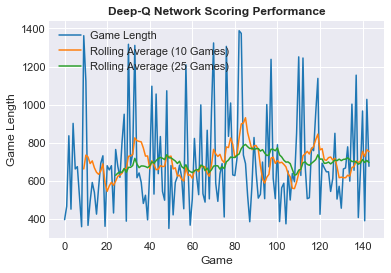

In [13]:
rolling_mean_gl_10 = pd.Series(run_dict['game length']).rolling(10).mean()
rolling_mean_gl_25 = pd.Series(run_dict['game length']).rolling(25).mean()

# Plot 
fig = plt.figure()

ax = fig.add_subplot(111)

plt.plot(run_dict['game'], run_dict['game length'], label = 'Game Length')
plt.plot(run_dict['game'], rolling_mean_gl_10, label = 'Rolling Average (10 Games)')
plt.plot(run_dict['game'], rolling_mean_gl_25, label = 'Rolling Average (25 Games)')

plt.title('Deep-Q Network Scoring Performance', fontweight = 'bold')

plt.xlabel('Game')
plt.ylabel('Game Length')

plt.legend()